In [316]:
from obspy.clients.fdsn import Client
from obspy import UTCDateTime
from scipy.io import savemat #for save obspy object as matlab format

In [317]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 15, 4
plt.rcParams['lines.linewidth'] = 0.5

In [318]:
client = Client("IRIS")
inventory = client.get_stations(
    starttime=t-180, endtime=t+180,
    longitude=lon, latitude=lat, maxradius=10,
    matchtimeseries=None)
print(inventory)

Inventory created at 2022-05-12T14:20:17.438000Z
	Created by: IRIS WEB SERVICE: fdsnws-station | version: 1.1.48
		    http://service.iris.edu/fdsnws/station/1/query?starttime=2017-04-03...
	Sending institution: IRIS-DMC (IRIS-DMC)
	Contains:
		Networks (8):
			8A, AF, GE, GT, IU, NR, SY, ZT
		Stations (180):
			8A.BAHE (Namibia)
			8A.GAMM (Namibia)
			8A.HELM (Namibia)
			8A.HOCH (Namibia)
			8A.KANO (Namibia)
			8A.NEPA (Namibia)
			8A.OKAM (Namibia)
			8A.OMUT (Namibia)
			8A.OTJO (Namibia)
			8A.WEWE (Namibia)
			AF.BLWY (Bulawayo, Zimbabwe)
			AF.CNG (Changalane Maputo Province Mozambique)
			AF.CRLN (Carolina, Mapumpalanga, South Africa)
			AF.HVD (Gariep Dam CMG-40T Earth data Low gain)
			AF.MONG (Mongu, Zambia, Africa)
			AF.MOPA (Mopani Camp, Kruger National Park, RSA)
			AF.MUSN (Musina, Limpopo, South Africa)
			AF.PKA (Prieska CMG-40T Earth data Low gain)
			AF.POGA (Pongola, Kwazulu-Natal, South Africa)
			AF.RUDU (Rundu, Ovamboland, Namibia)
			AF.SNKL (Senekal, Freesta

In [319]:
#2017-4-3T17:40:18
t = UTCDateTime(2017, 4, 3, 17, 40, 18)
lon = 25.1558
lat = -22.6784

In [320]:
station_list = ["NE208","NE212"] #NE201 NE209 NE220 No data 

In [321]:
for sta in station_list:
    print(sta)

NE208
NE212


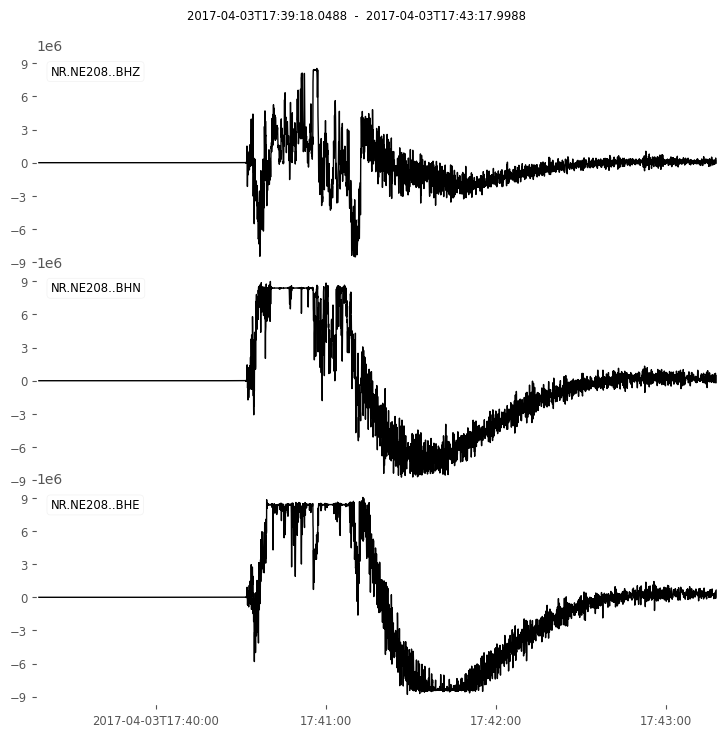

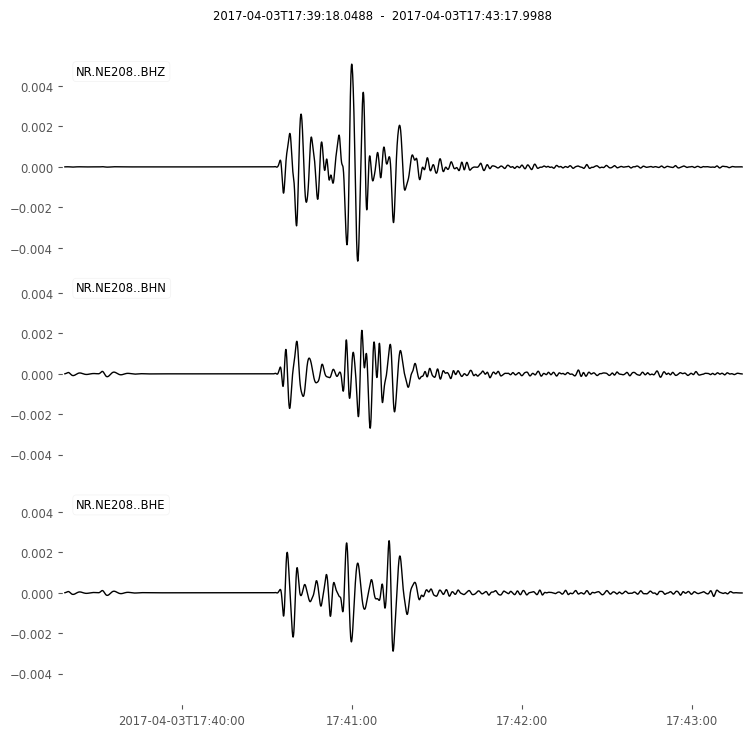

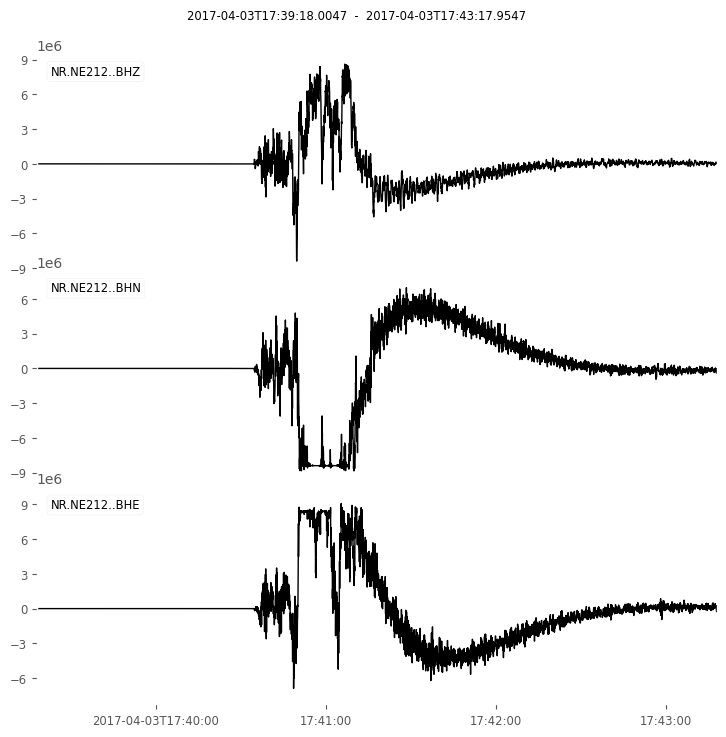

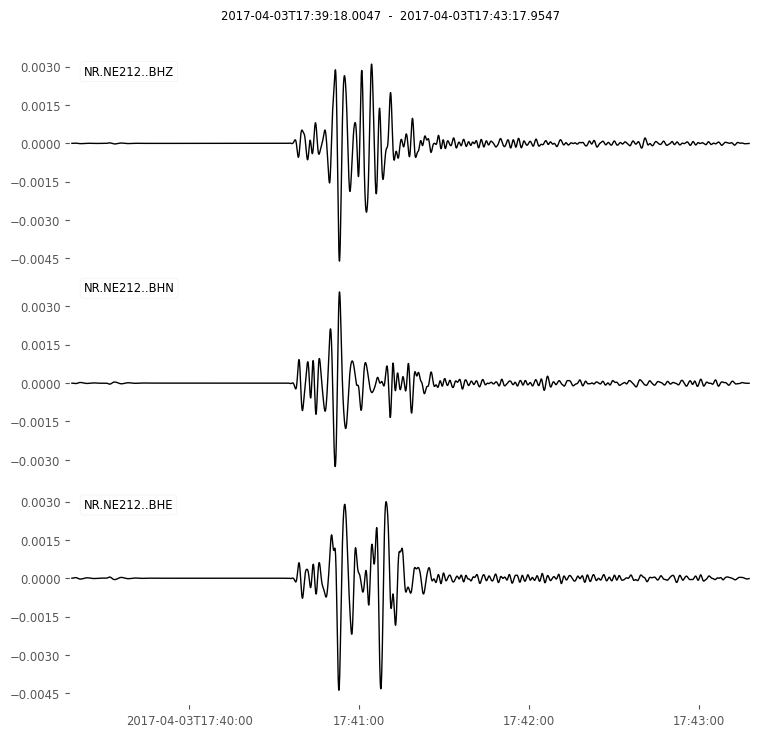

In [323]:
for sta in station_list:
    st = client.get_waveforms("NR", sta, "", "BH?", t-60, t+180)
    st.plot();#Plot RAW data
    inv = client.get_stations(network="NR", station=sta, location="", channel="BH?",
                     starttime=t-20, endtime=t+180, level="response")
    #instrument removed + filter + DISP
    st.slice(endtime=t+180).copy().remove_response(inventory=inv, output="DISP").taper(0.05).filter("bandpass", 
    freqmin=0.2, freqmax=0.6, corners=4).plot();
    for i, tr in enumerate(trace):
        mdict = {k: str(v) for k, v in tr.stats.items()} #change iteritems to items
        mdict['data'] = tr.data
        savemat("data-" + str(sta) + "_" + str(i) + "DISP" +".mat", mdict) #change like this
   


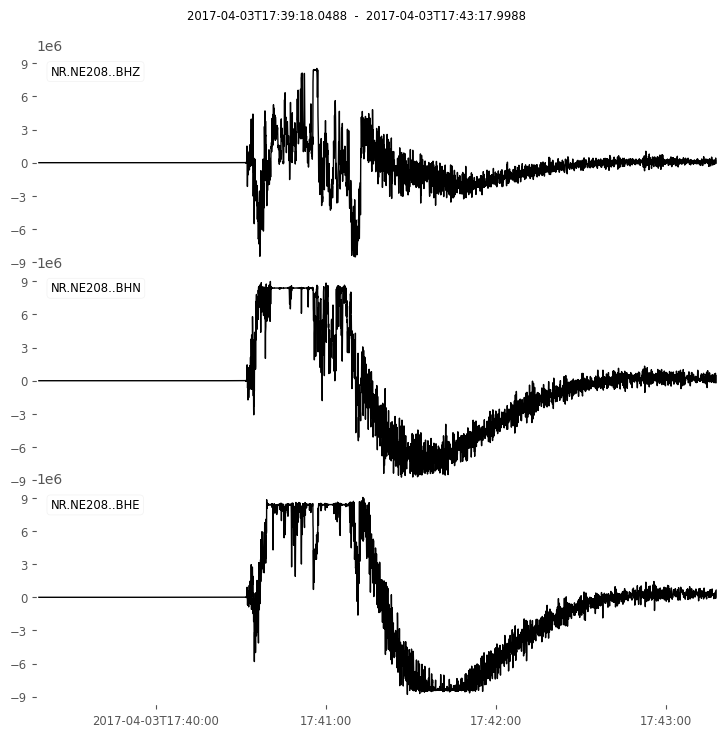

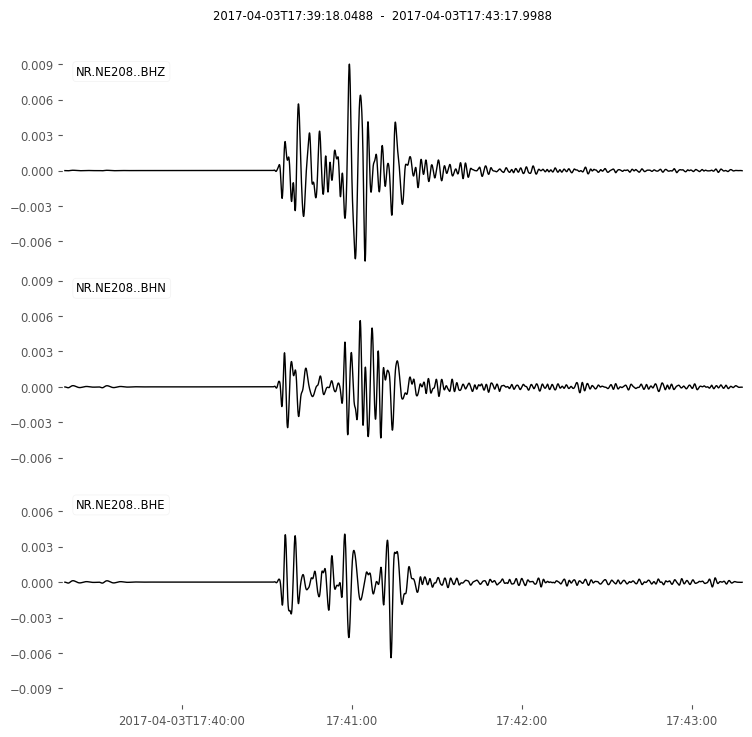

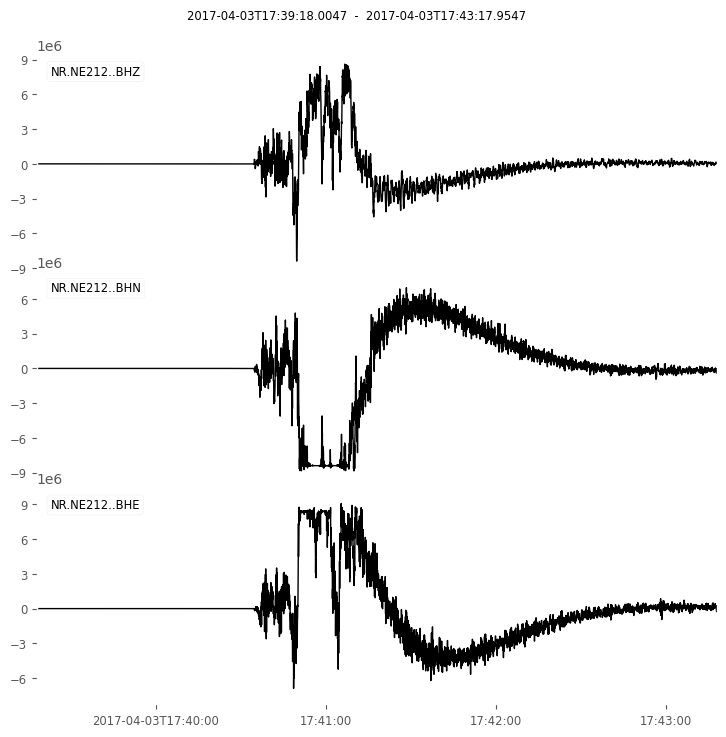

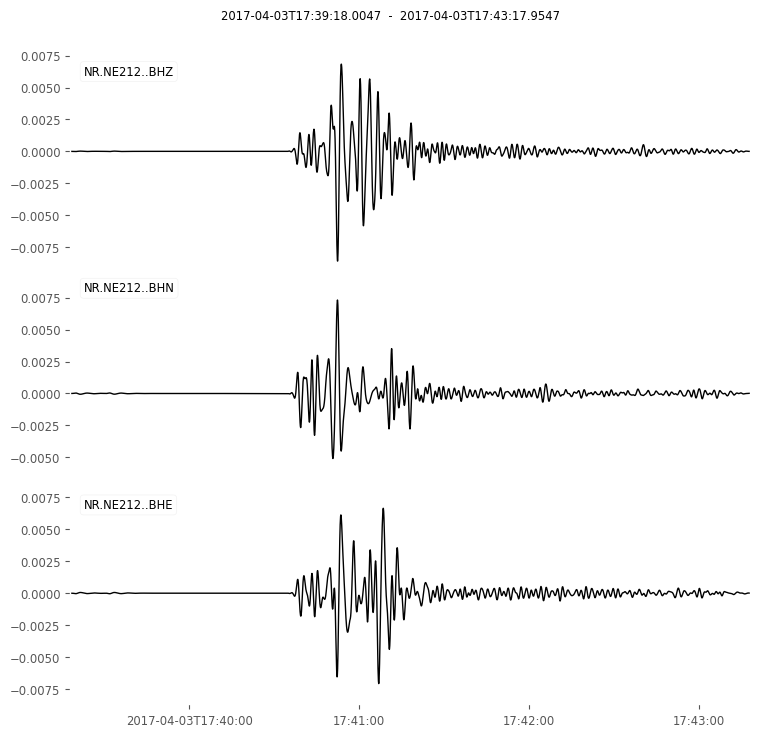

In [324]:
for sta in station_list:
    st = client.get_waveforms("NR", sta, "", "BH?", t-60, t+180)
    st.plot();#Plot RAW data
    inv = client.get_stations(network="NR", station=sta, location="", channel="BH?",
                     starttime=t-60, endtime=t+180, level="response")
    #instrument removed + filter + VEL
    trace = st.slice(endtime=t+180).copy().remove_response(inventory=inv, output="VEL").taper(0.05).filter("bandpass", 
    freqmin=0.2, freqmax=0.6, corners=4);
    trace.plot();
    for i, tr in enumerate(trace):
        mdict = {k: str(v) for k, v in tr.stats.items()} #change iteritems to items
        mdict['data'] = tr.data
        savemat("data-" + str(sta) + "_" + str(i) + "VEL" +".mat", mdict) #change like this

In [325]:
inv = client.get_stations(starttime=t-180, endtime=t+180,
    minlatitude=lat-2,
    maxlatitude=lat+2,
    minlongitude=lon-2,
    maxlongitude=lon+2,network="NR",
    matchtimeseries=None)
print(inv)

Inventory created at 2022-05-12T14:21:47.588000Z
	Created by: IRIS WEB SERVICE: fdsnws-station | version: 1.1.48
		    http://service.iris.edu/fdsnws/station/1/query?starttime=2017-04-03...
	Sending institution: IRIS-DMC (IRIS-DMC)
	Contains:
		Networks (1):
			NR
		Stations (5):
			NR.NE201 (Sekoma)
			NR.NE208 (Khwee)
			NR.NE209 (CKGR)
			NR.NE212 (Kaudwane)
			NR.NE220 (Lephepe)
		Channels (0):



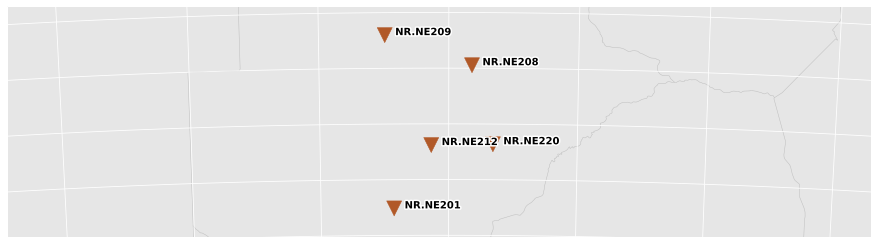

In [326]:
net = inv
net.plot(projection="local");  

In [271]:
st = client.get_waveforms("NR", "NE220", "", "BH?", t-20, t+180)

FDSNNoDataException: No data available for request.
Detailed response of server:

